In [10]:
import os 
import sys

proj_root = os.path.dirname(os.path.abspath("."))
# print(proj_root)
sys.path.append(proj_root)

import time
import datetime
import torch
import random
import numpy as np
import os
from pathlib import Path
import argparse

import torch.optim as optim
import torch.nn.functional as F

import gym 
import yaml

from minatar_dqn.replay_buffer import ReplayBuffer
from minatar_dqn.utils.my_logging import setup_logger
from minatar_dqn.models import Conv_QNET, Conv_QNET_one

from experiments.experiment_utils import (
    seed_everything,
    search_files_containing_string,
    split_path_at_substring,
    collect_training_output_files,
)

from minatar_dqn.my_dqn import Conv_QNET, build_environment
from minatar_dqn.redo import apply_redo_parametrization
from experiments.experiment_utils import collect_training_output_files, collect_pruning_output_files

from flatten_dict import flatten
import pandas as pd
import seaborn as sns
import scipy

sns.set()

import plotly
plotly.io.kaleido.scope.mathjax = None

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
training_timestamp_folder = "2023_05_22-08_44_19"

In [3]:
training_outputs_folder_path = (
    r"D:\Work\PhD\minatar_work\experiments\training\outputs"
)

experiment_paths = collect_training_output_files(
        os.path.join(training_outputs_folder_path, training_timestamp_folder)
    )

def get_records_from_training_experiment(experiment_files, stats_type = "validation"):
    
    checkpoint = torch.load(experiment_files["stats_path"])
    
    training_stats = checkpoint["training_stats"]
    validation_stats = checkpoint["validation_stats"]

    if stats_type == "training":
        flat_records = process_records_from_stats_and_config(training_stats, experiment_files["config_path"], stats_type)
    elif stats_type == "validation":
        flat_records = process_records_from_stats_and_config(validation_stats, experiment_files["config_path"], stats_type)
    
    return flat_records

def process_records_from_stats_and_config(stats, config_path, stats_type):

    flat_records = []
    for epoch_stats in stats:
        flat_stats = flatten(epoch_stats, reducer="underscore")  
        flat_stats["epoch_type"] = stats_type
        flat_records.append(flat_stats)

    with open(config_path, "r") as f:
        config = yaml.safe_load(f)

    # build experiment name cause I did not think to save some kind of 
    # exp name in config
    config_file_name = os.path.basename(config_path)

    # add info from the config file
    for record in flat_records:
        record["environment"] = config["environment"]
        record["seed"] = config["seed"]
        record["experiment_name"] = config["experiment_name"]
        
    return flat_records

def collect_training_experiment_results(experiment_paths, stats="validation", train_epoch_counter = 200_000):
    records = []
    for experiment_files in experiment_paths:
        if experiment_files: # in case experiment did not finish
            records.extend(get_records_from_training_experiment(experiment_files, stats_type=stats))

    df = pd.DataFrame.from_records(records)
    df["epoch"] = df["frame_stamp"] // train_epoch_counter 

    return df

df = collect_training_experiment_results(experiment_paths, stats="validation")
# df = collect_training_experiment_results(experiment_paths, stats="training")

print(df.shape)
df.head()

df["model_name"] = df["experiment_name"].map(lambda x: "_".join(x.split("_")[0:2]))
# df["model_name"]

(800, 22)


0      conv16_lin64
1      conv16_lin64
2      conv16_lin64
3      conv16_lin64
4      conv16_lin64
           ...     
795     conv8_lin32
796     conv8_lin32
797     conv8_lin32
798     conv8_lin32
799     conv8_lin32
Name: model_name, Length: 800, dtype: object

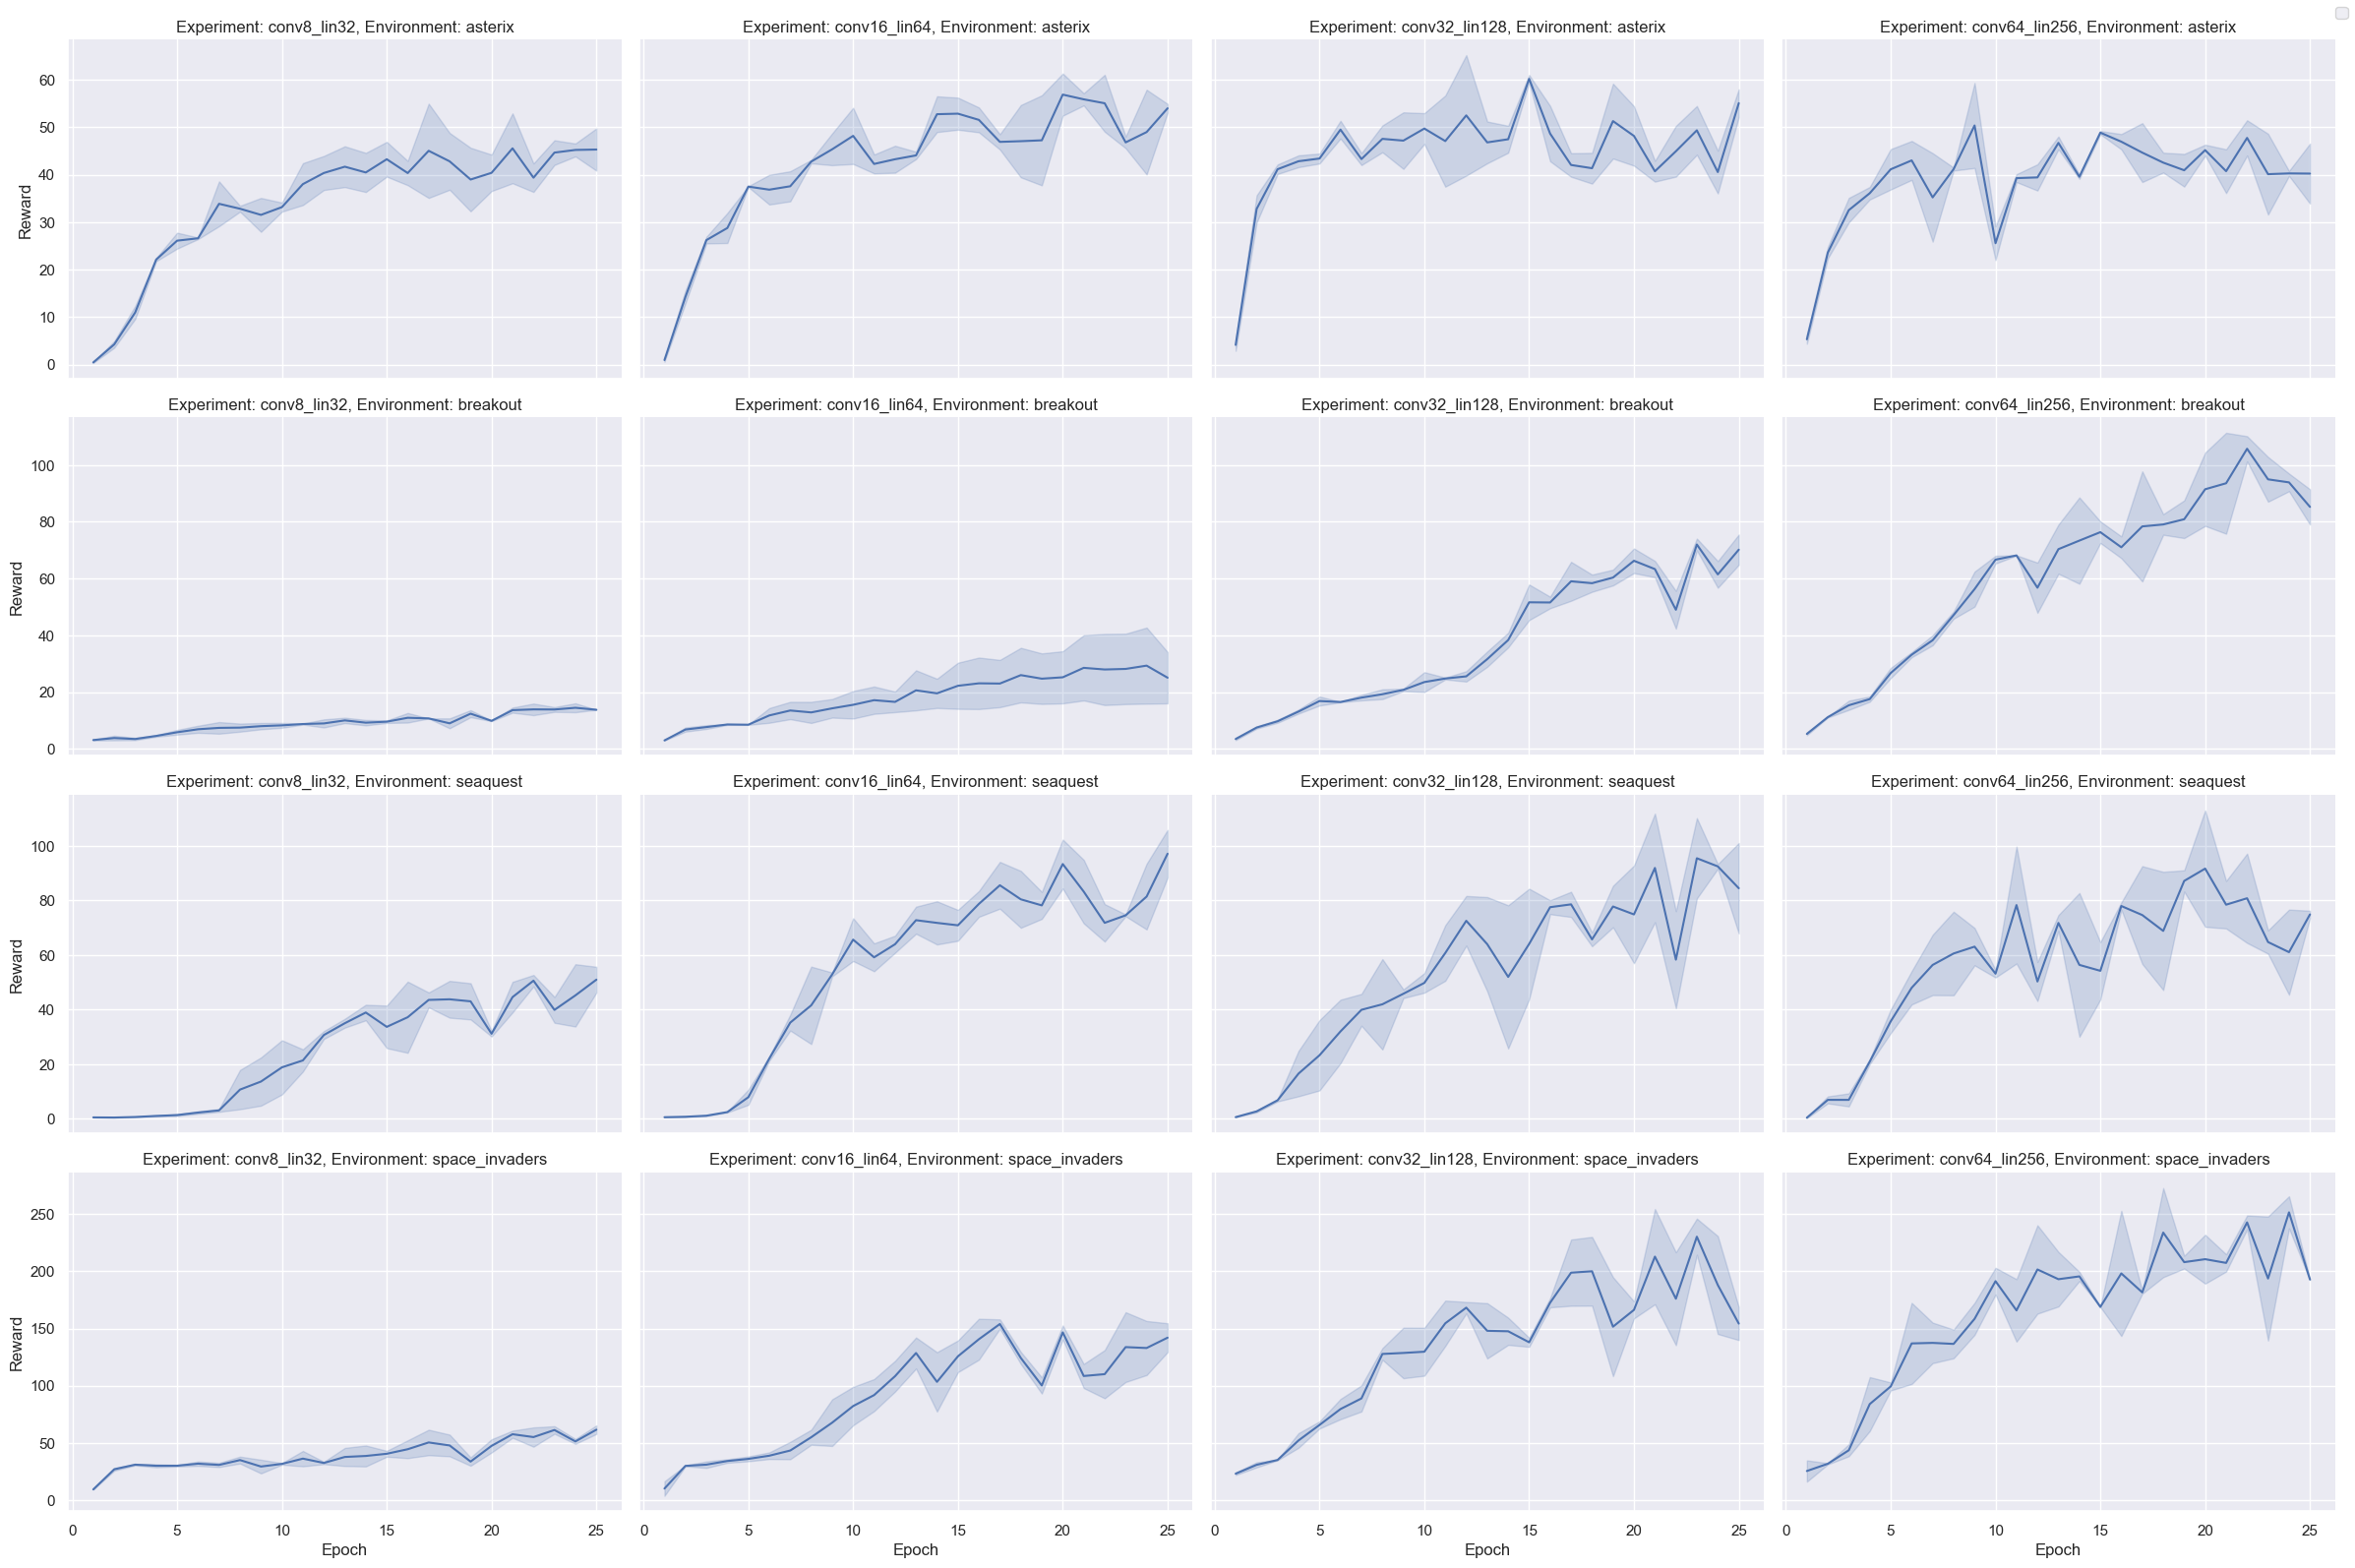

In [4]:
# MARK PLOT FOR POSTER

model_order = ["conv8_lin32", "conv16_lin64", "conv32_lin128", "conv64_lin256"]
g = sns.FacetGrid(df, row='environment', col='model_name', height=4, aspect=1.5, sharey="row", col_order=model_order)

g.map(sns.lineplot, 'epoch', 'episode_rewards_mean')

g.set_titles('Experiment: {col_name}, Environment: {row_name}')
g.set_xlabels('Epoch')
g.set_ylabels('Reward')

# Display the legend
handles, labels = plt.gca().get_legend_handles_labels()
g.fig.legend(handles, labels, loc='upper right')

plt.show()

In [5]:
pruning_outputs_folder_path = (
    r"D:\Work\PhD\minatar_work\experiments\pruning\outputs"
)
pruning_timestamp_folder = training_timestamp_folder

experiment_paths = collect_pruning_output_files(
        os.path.join(pruning_outputs_folder_path, pruning_timestamp_folder)
    )

In [6]:
def process_pruning_stats_file(file):

    checkpoint = torch.load(file)

    exp_stats = checkpoint["pruning_validation_results"]
    exp_info = checkpoint["experiment_info"]

    records = []
    for pruning_value in exp_stats:
        stats = exp_stats[pruning_value]
        stats["pruning_value"] = pruning_value
        stats["pruning_method"] = os.path.basename(file).split("_")[-1]
        stats["experiment_info"] = exp_info
        records.append(stats)

    return records

def add_baseline_stats(baseline_file, file):
    """Add a new record with the baseline stats and an associated 
    pruning_method just to make data aggregation easier."""
    checkpoint = torch.load(baseline_file)
    baseline_stats = checkpoint["pruning_validation_results"]
    baseline_info = checkpoint["experiment_info"]

    records = []
    for pruning_value in baseline_stats:
        stats = baseline_stats[pruning_value]
        stats["pruning_value"] = pruning_value
        stats["pruning_method"] = os.path.basename(file).split("_")[-1]
        stats["experiment_info"] = baseline_info

        records.append(stats)
        
    return records

def get_records_from_pruning_experiment(experiment_files):

    config_path = experiment_files["config_path"]

    stats = []
    for file in experiment_files["pruning_stats_paths"]:
        stats.extend(process_pruning_stats_file(file))
        stats.extend(add_baseline_stats(experiment_files["baseline_stats_path"], file))
    
    flat_records = []
    for epoch_stats in stats:
        flat_stats = flatten(epoch_stats, reducer="underscore")  
        flat_records.append(flat_stats)

    with open(config_path, "r") as f:
        config = yaml.safe_load(f)

    # build experiment name cause I did not think to save some kind of 
    # exp name in config
    config_file_name = os.path.basename(config_path)
    exp_name_tokens = config_file_name.split("_")[:2]
    exp_name = "_".join(exp_name_tokens)

    # add info from the config file
    for record in flat_records:
        record["environment"] = config["environment"]
        record["seed"] = config["seed"]
        record["model_name"] = exp_name

    return flat_records
    
def collect_pruning_experiment_results(experiment_paths):

    records = []
    for experiment_files in experiment_paths:
        records.extend(get_records_from_pruning_experiment(experiment_files))

    df = pd.DataFrame.from_records(records)
    # df["epoch"] = df["frame_stamp"] // train_epoch_counter 

    return df

df = collect_pruning_experiment_results(experiment_paths)

pruning_method_nr_to_name = {
    '1': 'prune_middle',
    '2': 'prune_features',
    '3': 'prune_all',
    '4': 's_prune_conv'
}

# Map the 'fruit' column to 'color'
df['pruning_method'] = df['pruning_method'].map(pruning_method_nr_to_name)

df.head()

,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_frames_min,episode_frames_max,episode_frames_mean,episode_frames_median,...,model_name,reward_contor_7,reward_contor_5,reward_contor_6,reward_contor_4,reward_contor_2,reward_contor_9,reward_contor_8,reward_contor_3,reward_contor_10
0,0,0.0,255.0,47.784431,42.0,38.793653,48,2094,751.191617,819.0,...,conv16_lin64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1.0,203.0,51.829114,49.0,40.691521,61,1915,791.797468,849.0,...,conv16_lin64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.0,170.0,50.910256,47.0,33.766804,44,1507,803.358974,903.5,...,conv16_lin64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0.0,137.0,48.254658,48.0,33.277355,29,1393,776.552795,925.0,...,conv16_lin64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0.0,138.0,39.392265,35.0,29.318705,59,1491,696.790055,756.0,...,conv16_lin64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def normalize_df_using_baseline_single_env(df):
    
    cols_to_not_normalize = ['frame_stamp', 'epoch_time', 'pruning_value', 'pruning_method',
       'experiment_info', 'environment', 'seed', 'model_name']

    # Find the baseline values
    baseline = df[(df["pruning_value"] == 0)]

    groups = df.groupby(["model_name", "seed"])

    for (model_name, seed), group in groups:
    
        for metric in group.columns.difference(cols_to_not_normalize):

            # Get the baseline value for this metric and model/seed/pruning_method combination
            baseline_value = baseline[(baseline["model_name"] == model_name) & (baseline["seed"] == seed)][metric].iloc[0]
        
            # Normalize the values for this metric by the baseline value
            group[metric] /= baseline_value
            
            # Store the normalized values back in the original DataFrame
            df.loc[group.index, metric] = group[metric]

    return df

def normalize_df_using_baseline_all_envs(df):
    
    cols_to_not_normalize = ['frame_stamp', 'epoch_time', 'pruning_value', 'pruning_method',
       'experiment_info', 'environment', 'seed', 'model_name']

    # Find the baseline values
    baseline = df[(df["pruning_value"] == 0)]

    groups = df.groupby(["environment", "model_name", "seed"])

    for (environment, model_name, seed), group in groups:
    
        for metric in group.columns.difference(cols_to_not_normalize):

            # Get the baseline value for this metric and model/seed/pruning_method combination
            baseline_value = baseline[(baseline["environment"] == environment) & (baseline["model_name"] == model_name) & (baseline["seed"] == seed)][metric].iloc[0]
        
            # Normalize the values for this metric by the baseline value
            group[metric] /= baseline_value
            
            # Store the normalized values back in the original DataFrame
            df.loc[group.index, metric] = group[metric]

    return df

def plot_facetgrid_experiment(df, y_label = "Mean score", title="Mean score at different levels of pruning"):

    experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

    # Compute the average metric between the seeds for each experiment
    # avg_df = df.groupby(['environment', 'experiment_name', 'epoch']).mean().reset_index()

    g = sns.FacetGrid(df, row='pruning_method', col='model_name', col_order=experiment_order, 
    height=3, aspect=1, sharey="row")
    g.map(sns.lineplot, 'pruning_value', 'episode_rewards_mean')

    # Set the plot title and axis labels
    g.fig.suptitle(title)
    g.set_titles(row_template='{row_name}', col_template='{col_name}', fontsize=1)

    g.figure.subplots_adjust(top=0.9, wspace=0.1)
    g.set_axis_labels('Pruning factor', y_label)

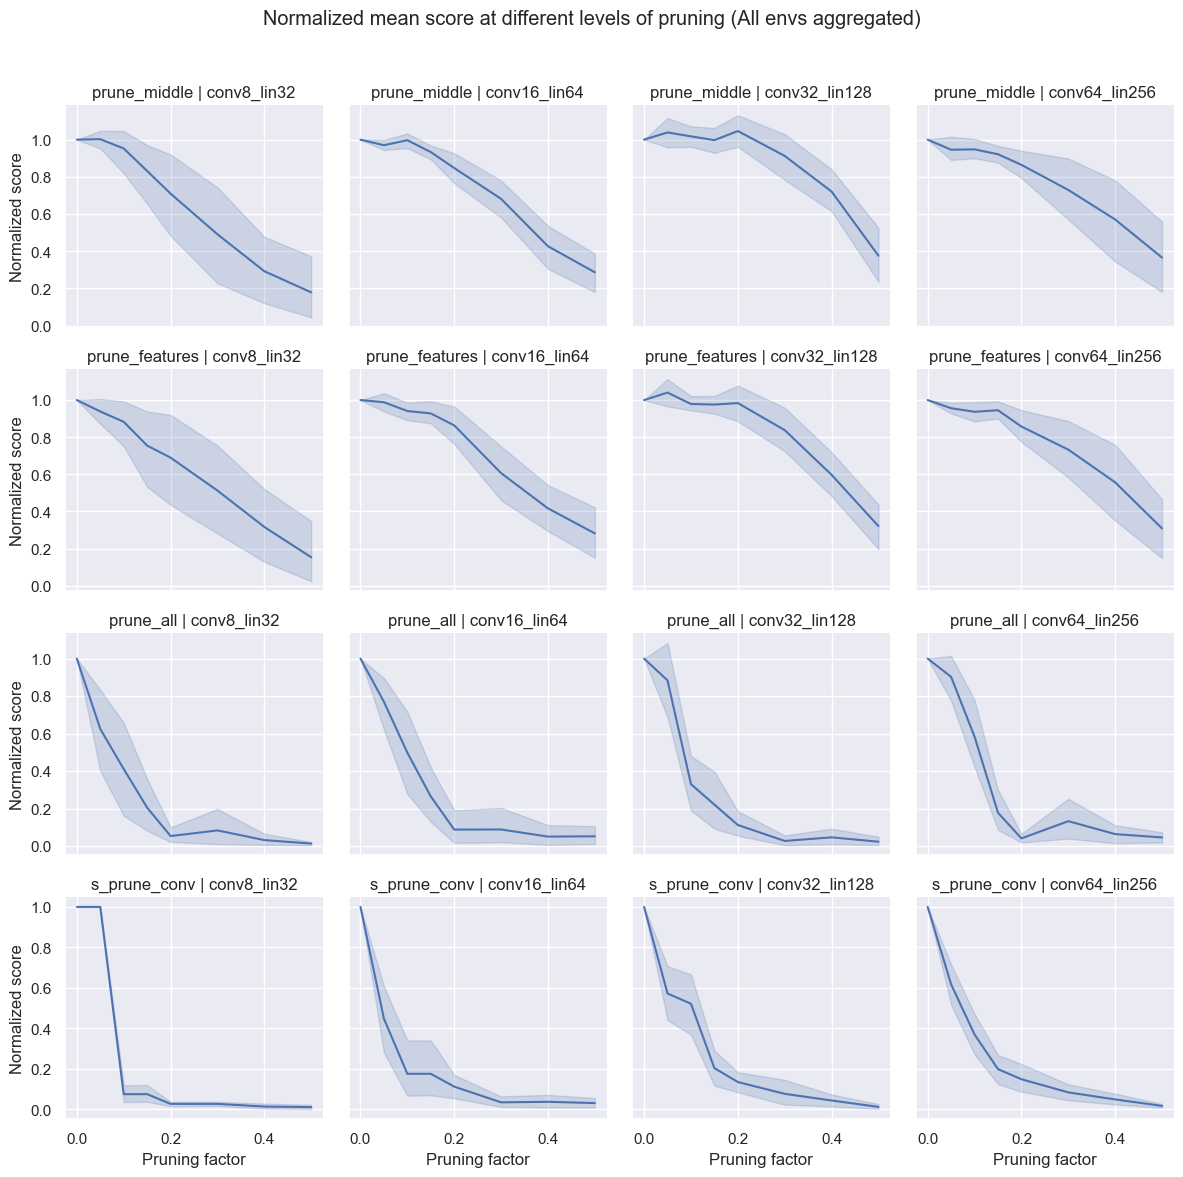

In [8]:
# MARK: needed for poster

sub_df = df.copy(deep=True)
sub_df = normalize_df_using_baseline_all_envs(sub_df)

plot_facetgrid_experiment(sub_df, y_label = "Normalized score", title=f"Normalized mean score at different levels of pruning (All envs aggregated)")

# Show the plot
plt.show()

In [11]:
def mask_to_score_distance(mask, scores):
    num_ones = np.count_nonzero(mask)

    if num_ones == 0:
        return 0
    
    # Sort the scores in ascending order and get their corresponding indices
    sorted_indices = np.argsort(scores)
    
    # Create a new mask where the N smallest values represent True
    new_mask = torch.zeros_like(mask, dtype=torch.bool)
    new_mask[sorted_indices[:num_ones]] = True
     
    # Calculate the Hamming distance between the masks
    hamming_distance = torch.sum(torch.logical_and(mask, new_mask))
    hamming_relative_distance = hamming_distance.item() / len(mask)

    return hamming_relative_distance

def mask_vs_norm_stats(mask, scores):
    num_ones = np.count_nonzero(mask)
    
    # Sort the scores in ascending order and get their corresponding indices
    sorted_indices = np.argsort(scores)
    
    # Create a new mask where the N smallest values represent True
    new_mask = torch.zeros_like(mask, dtype=torch.bool)
    new_mask[sorted_indices[:num_ones]] = True
     
    # Calculate the Hamming distance between the masks
    only_redo = torch.sum(torch.logical_and(mask, torch.eq(new_mask, False))).item() 
    intersect = torch.sum(torch.logical_and(mask, new_mask)).item() 
    only_pruning = torch.sum(torch.logical_and(torch.eq(mask, False), new_mask)).item()

    return only_redo, intersect, only_pruning

def get_rankings(scores):
    sorted_indices = torch.argsort(scores)

    # Initialize tensor for rankings
    rankings = torch.zeros_like(scores, dtype=torch.long)

    # Assign ranks to scores
    rankings[sorted_indices] = torch.arange(1, len(scores) + 1)

    return rankings

def compare_redo_pruning(exp_paths):

    training_stats_data = torch.load(exp_paths["stats_path"])
    redo_scores = training_stats_data["redo_scores"]["policy"]

    checkpoints_paths = search_files_containing_string(
        exp_paths["models_folder_path"], "mck", substring_location="containing"
    )

    # read the config so that the model architecture can be loaded
    with open(exp_paths["config_path"], "r") as ymlfile:
        cfg = yaml.safe_load(ymlfile)

    results = []
    for checkpoint_path in checkpoints_paths:
        
        # Build a new model
        validation_env = build_environment(
            cfg["environment"], cfg["seed"]
        )

        # returns state as [w, h, channels]
        state_shape = validation_env.observation_space.shape

        # permute to get batch, channel, w, h shape
        # specific to minatar
        in_features = (state_shape[2], state_shape[0], state_shape[1])
        in_channels = in_features[0]
        num_actions = validation_env.action_space.n

        checkpoint_model = Conv_QNET(in_features = in_features, 
                                    in_channels = in_channels, 
                                    num_actions = num_actions, 
                                    **cfg["estimator"]["args_"])
        checkpoint_model = apply_redo_parametrization(checkpoint_model, tau=0.1)

        # Get the state of the model
        checkpoint_models_state = torch.load(checkpoint_path)
        checkpoint_model.load_state_dict(checkpoint_models_state["policy_model_state_dict"])
        model_state = checkpoint_model.state_dict()

        # Compute kendall rank correlation coefficient for each layer
        layer_weight_keys = ["features.0.weight", "features.2.weight", "fc.0.weight"]
        for i, layer_key in enumerate(layer_weight_keys):
            weights = model_state[layer_key]

            # compute the weight of the neurons in this layer
            if weights.dim() > 2:
                l1_norms = torch.sum(torch.abs(weights), dim=(1, 2, 3))
            else:
                l1_norms = torch.sum(torch.abs(weights), dim=(1))

            neuron_rankings = get_rankings(l1_norms)
        
            check_index = int(os.path.basename(checkpoint_path).split("_")[1]) - 1 # get the index of the checkpoint
            
            redo_score = redo_scores[check_index][i]
            redo_rankings = get_rankings(torch.tensor(redo_score))

            k_corr, k_pval = scipy.stats.kendalltau(neuron_rankings, redo_rankings)
            s_corr, s_pval = scipy.stats.spearmanr(neuron_rankings, redo_rankings)
            p_corr, p_pval = scipy.stats.pearsonr(l1_norms, redo_score)

            # also do an experiment with thresholding  

            tau_vals = [0.025, 0.1]

            for tau in tau_vals:
                dormant_neurons_mask = (redo_score <= tau)
                
                dormant_neurons_idx = dormant_neurons_mask.nonzero().flatten()

                only_redo, intersect, only_pruning = mask_vs_norm_stats(
                    dormant_neurons_mask, l1_norms
                )

                new_row = {"seed": cfg["seed"],
                        "env": cfg["environment"],
                        "experiment": "_".join(cfg["experiment_name"].split("_")[:2]), # WARNING
                        "tau": tau,
                        "nr_only_redo": only_redo,
                        "nr_intersect": intersect,
                        "nr_only_pruning": only_pruning,
                        "dead_neuron_l1norms": l1_norms[dormant_neurons_idx],
                        "dead_neuron_l1norms_avg": np.average(l1_norms[dormant_neurons_idx]),
                        "dead_neuron_ratio": len(dormant_neurons_idx) / len(redo_score),
                        "redo_l1norm_hamming": mask_to_score_distance(dormant_neurons_mask, l1_norms),
                        "checkpoint": os.path.basename(checkpoint_path),
                        "epoch": check_index, 
                        "layer": layer_key,
                        "kendall_r_corr": k_corr, 
                        "kendall_r_pval": k_pval,
                        "spearman_r_corr": s_corr, 
                        "spearman_r_pval": s_pval,
                        "pearson_corr": p_corr, 
                        "pearson_pval": p_pval
                        }
                results.append(new_row)

    df = pd.DataFrame(results)

    return df 
    

In [13]:
# Collect all paths to models in a specified folder
training_outputs_folder_path = os.path.join(proj_root, "experiments", "training", "outputs")
pruning_outputs_folder_path = os.path.join(proj_root, "experiments", "pruning", "outputs")

experiments_folder = os.path.join(training_outputs_folder_path, training_timestamp_folder)

experiment_paths = collect_training_output_files(
        os.path.join(training_outputs_folder_path, training_timestamp_folder)
    )

for exp in experiment_paths:
    exp["models_folder_path"] = os.path.dirname(exp["model_path"])

exp_analysis_results = []

for exp_paths in experiment_paths:
    exp_analysis_results.append(compare_redo_pruning(exp_paths))

# concatenate the dataframes vertically
df_res = pd.concat(exp_analysis_results)
df_res

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\envs\registration.py:555: UserWarning:

WARN: The environment MinAtar/Asterix-v0 is out of date. You should consider upgrading to version `v1`.

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:20: UserWarning:

WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: bool. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:25: UserWarning:

WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_27480\464247714.py:105: UserWarning:

To copy construct from a 

,seed,env,experiment,tau,nr_only_redo,nr_intersect,nr_only_pruning,dead_neuron_l1norms,dead_neuron_l1norms_avg,dead_neuron_ratio,redo_l1norm_hamming,checkpoint,epoch,layer,kendall_r_corr,kendall_r_pval,spearman_r_corr,spearman_r_pval,pearson_corr,pearson_pval
0,0,asterix,conv16_lin64,0.025,3,4,3,"[tensor(3.3978), tensor(2.9052), tensor(3.8876...",3.711692,0.43750,0.250000,mck_1,0,features.0.weight,0.350000,6.411343e-02,0.450000,8.029574e-02,0.473772,6.376420e-02
1,0,asterix,conv16_lin64,0.100,2,10,2,"[tensor(3.3978), tensor(2.9052), tensor(3.6997...",3.808709,0.75000,0.625000,mck_1,0,features.0.weight,0.350000,6.411343e-02,0.450000,8.029574e-02,0.473772,6.376420e-02
2,0,asterix,conv16_lin64,0.025,2,2,2,"[tensor(7.4492), tensor(8.2096), tensor(6.0271...",6.731621,0.25000,0.125000,mck_1,0,features.2.weight,0.183333,3.501953e-01,0.244118,3.622135e-01,0.286141,2.826493e-01
3,0,asterix,conv16_lin64,0.100,3,8,3,"[tensor(8.8033), tensor(8.1095), tensor(7.4492...",7.831610,0.68750,0.500000,mck_1,0,features.2.weight,0.183333,3.501953e-01,0.244118,3.622135e-01,0.286141,2.826493e-01
4,0,asterix,conv16_lin64,0.025,1,45,1,"[tensor(12.2215), tensor(12.0013), tensor(12.1...",12.138257,0.71875,0.703125,mck_1,0,fc.0.weight,0.588294,6.364803e-12,0.747848,1.242029e-12,0.942497,3.299078e-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1,space_invaders,conv8_lin32,0.100,1,2,1,"[tensor(8.6357), tensor(7.8074), tensor(7.6687)]",8.037274,0.37500,0.250000,mck_9,8,features.0.weight,0.642857,3.115079e-02,0.761905,2.800494e-02,0.751124,3.170254e-02
146,1,space_invaders,conv8_lin32,0.025,1,0,1,[tensor(10.5037)],10.503723,0.12500,0.000000,mck_9,8,features.2.weight,0.071429,9.048611e-01,0.142857,7.357649e-01,0.575495,1.355253e-01
147,1,space_invaders,conv8_lin32,0.100,2,3,2,"[tensor(9.0654), tensor(11.7338), tensor(10.50...",9.368734,0.62500,0.375000,mck_9,8,features.2.weight,0.071429,9.048611e-01,0.142857,7.357649e-01,0.575495,1.355253e-01
148,1,space_invaders,conv8_lin32,0.025,3,17,3,"[tensor(8.4035), tensor(30.2413), tensor(22.54...",15.201574,0.62500,0.531250,mck_9,8,fc.0.weight,0.600806,2.423272e-07,0.784091,1.102979e-07,0.644400,6.881498e-05


Text(0.5, 0.98, 'dead_neuron_ratio')

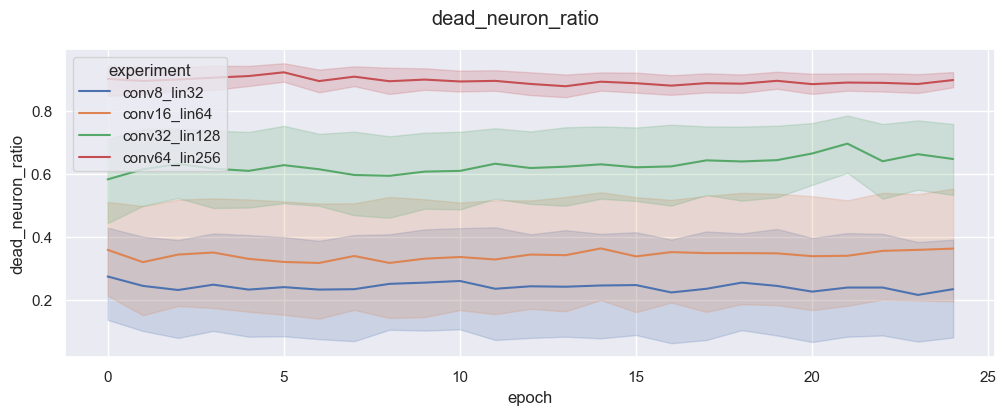

In [15]:
metric_col = 'dead_neuron_ratio'

experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

sub_df = df_res[df_res["tau"] == 0.025]

# Compute the average metric between the seeds for each experiment
avg_df = sub_df.groupby(['env', 'experiment', 'epoch', "layer"]).mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(avg_df, x="epoch", y=metric_col, hue='experiment', hue_order = experiment_order, ax = ax)

fig.suptitle(metric_col)

In [19]:

experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

for layer in df_res["layer"].unique():
    # sub_df = df_res[(df_res["tau"] == 0.025) & (df_res["layer"] == layer)]

    # melted_df = sub_df.melt(id_vars=['env', 'experiment', 'epoch'],
    #                         value_vars=['nr_only_redo', 'nr_intersect', 'nr_only_pruning'],
    #                         var_name='Category', value_name='Value')

    # fig = px.bar(melted_df, x="epoch", y="Value", color="Category", facet_row="env", facet_col="experiment",
    #             category_orders={"experiment": experiment_order}, 
    #             height=600)
    
    # title = f"Redo and Norm overlap - Layer {layer} shared Y"
    # file_path = f"imgs/{title}.png"

    # # Save the figure as a PNG image
    # pio.write_image(fig, file_path)

    # fig.update_layout(title=title)
    # fig.show()


    melted_df = sub_df.melt(id_vars=['env', 'experiment', 'epoch'],
                            value_vars=['nr_only_redo', 'nr_intersect', 'nr_only_pruning'],
                            var_name='Category', value_name='Value')

    fig = px.bar(melted_df, x="epoch", y="Value", color="Category", facet_row="env", facet_col="experiment",
                category_orders={"experiment": experiment_order}, height=600)

    fig.update_yaxes(matches=None, showticklabels=True)

    title = f"Redo and Norm overlap - Layer {layer}"
    file_path = f"imgs/{title}.png"
    
    # Save the figure as a PNG image
    pio.write_image(fig, file_path)

    fig.update_layout(title=title)

    fig.show()